# 類似性アルゴリズムを用いたエンティティマッチングの補足


書籍のリスト 9-21 では、少数のサンプルのみを比較してトークンベースのアプローチの方が頑健であるという評価をしています。

この notebook では、マッチングの正解データを使って、トークンベースと文字列ベースのアプローチの定量的な比較を行います。


## 前提

- リスト 9-19 を実行済みである。


## 前準備


アノテーションデータをダウンロードする。


In [ ]:
!mkdir ./data

# https://data.dws.informatik.uni-mannheim.de/benchmarkmatchingtasks/index.html
!wget https://data.dws.informatik.uni-mannheim.de/benchmarkmatchingtasks/data/amazon-google/gs_train.csv -O ./data/train.csv
!wget https://data.dws.informatik.uni-mannheim.de/benchmarkmatchingtasks/data/amazon-google/gs_val.csv -O ./data/val.csv
!wget https://data.dws.informatik.uni-mannheim.de/benchmarkmatchingtasks/data/amazon-google/gs_test.csv -O ./data/test.csv

In [2]:
import os
from neo4j import GraphDatabase
from tqdm import tqdm


neo4j_client = GraphDatabase.driver(
    os.environ.get("NEO4J_URI", "bolt://localhost:7687"),
    auth=(
        os.environ.get("NEO4J_USER", "neo4j"),
        os.environ.get("NEO4J_PASSWORD", "yolo"),
    ),
)
neo4j_client.verify_connectivity()

## データの加工と不整合確認


In [ ]:
import polars as pl

train_df = pl.read_csv("./data/train.csv")
eval_df = pl.read_csv("./data/val.csv")
eval_df = eval_df.vstack(pl.read_csv("./data/test.csv"))

アノテーションデータ内に含まれているすべての商品が Neo4j 内に存在するか確認する。


In [ ]:
source_ids = train_df["source_id"].to_list() + eval_df["source_id"].to_list()
target_ids = train_df["target_id"].to_list() + eval_df["target_id"].to_list()
missing_ids = []
for source_id, target_id in tqdm(zip(source_ids, target_ids)):
    stmt = """
    MATCH (p:Product {id: $id})
    RETURN p.id as id
    """
    with neo4j_client.session() as session:
        result = session.run(stmt, id=source_id)
        records = [r for r in result.data()]
        if len(records) == 0:
            print(f"Source ID {source_id} not found")
            missing_ids.append(source_id)

        result = session.run(stmt, id=target_id)
        records = [r for r in result.data()]
        if len(records) == 0:
            print(f"Target ID {target_id} not found")
            missing_ids.append(target_id)
assert len(missing_ids) == 0

8440it [00:41, 203.00it/s]


## 類似度の算出


### トークンベース


In [8]:
stmt = """\
CALL gds.nodeSimilarity.stream('identity-sim', {similarityCutoff: 0.0}) YIELD node1, node2, similarity
RETURN gds.util.asNode(node1).id as source_id, gds.util.asNode(node2).id as target_id, similarity"""

token_based_result = {}
with neo4j_client.session() as session:
    result = session.run(stmt)
    for record in tqdm(result):
        key = "-".join(sorted([record["source_id"], record["target_id"]]))
        token_based_result[key] = record["similarity"]

45890it [00:01, 27171.70it/s]


### 文字列ベース（Jaro-Winkler 距離）


In [45]:
stmt = """\
MATCH (sp:Product), (tp:Product)
WHERE sp.id < tp.id
RETURN sp.id as source_id, 
  tp.id as target_id, 
  1 - apoc.text.jaroWinklerDistance(
    CASE
      WHEN sp.source = 'GGL' THEN sp.name
      WHEN sp.source = 'AMZ' THEN sp.title
      ELSE null
    END, 
    CASE
      WHEN tp.source = 'GGL' THEN tp.name
      WHEN tp.source = 'AMZ' THEN tp.title
      ELSE null
    END
  ) AS similarity
"""

jaro_winkler_based_result = {}
with neo4j_client.session() as session:
    result = session.run(stmt)
    for record in tqdm(result):
        key = "-".join(sorted([record["source_id"], record["target_id"]]))
        jaro_winkler_based_result[key] = record["similarity"]

10527166it [03:33, 49399.20it/s]


In [ ]:
def assign_similarity(df, token_based_result: dict, jaro_winkler_based_result: dict):
    df = df.with_columns(
        pl.struct(["source_id", "target_id"])
        .map_elements(
            lambda x: "-".join(sorted([x["source_id"], x["target_id"]])),
            return_dtype=pl.String,
        )
        .alias("key")
    )
    df = df.with_columns(
        pl.struct(["key"])
        .map_elements(
            lambda x: token_based_result.get(x["key"], 0.0),
            return_dtype=pl.Float32,
        )
        .alias("token_based_similarity"),
    )
    df = df.with_columns(
        pl.struct(["key"])
        .map_elements(
            lambda x: jaro_winkler_based_result.get(x["key"], 0.0),
            return_dtype=pl.Float32,
        )
        .alias("jaro_winkler_based_similarity"),
    )

    return df


train_df = assign_similarity(train_df, token_based_result, jaro_winkler_based_result)
eval_df = assign_similarity(eval_df, token_based_result, jaro_winkler_based_result)

訓練データセットを使って、同一エンティティとして判断する類似度の閾値を決定する。


In [60]:
import numpy as np
from sklearn.metrics import f1_score, precision_score, recall_score

ths = np.linspace(1e-5, 1.0 - 1e-5, 100)
best_th_token_based_approach = 0.0
best_th_jaro_winkler_based_approach = 0.0
best_f1_token_based_approach = 0.0
best_f1_jaro_winkler_based_approach = 0.0
f1s_token_based_approach = []
f1s_jaro_winkler_based_approach = []
for th in ths:
    y_true = train_df["matching"].to_numpy()
    y_pred = (train_df["token_based_similarity"] > th).to_numpy()
    f1 = f1_score(y_true, y_pred)
    if f1 > best_f1_token_based_approach:
        best_th_token_based_approach = th
        best_f1_token_based_approach = f1
    f1s_token_based_approach.append(f1)

    y_pred = (train_df["jaro_winkler_based_similarity"] > th).to_numpy()
    f1 = f1_score(y_true, y_pred)
    if f1 > best_f1_jaro_winkler_based_approach:
        best_th_jaro_winkler_based_approach = th
        best_f1_jaro_winkler_based_approach = f1
    f1s_jaro_winkler_based_approach.append(f1)

閾値の変化によって F1 スコアがどのように変化するか確認する。


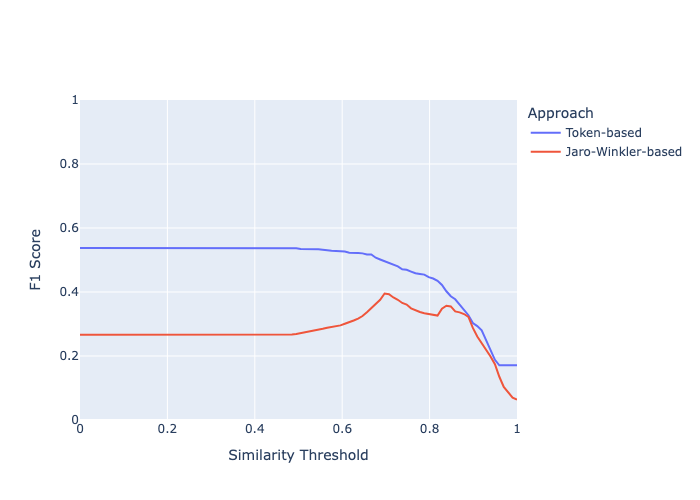

In [ ]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(
    go.Scatter(x=ths, y=f1s_token_based_approach, mode="lines", name="Token-based")
)
fig.add_trace(
    go.Scatter(
        x=ths,
        y=f1s_jaro_winkler_based_approach,
        mode="lines",
        name="Jaro-Winkler-based",
    )
)
fig.update_layout(
    xaxis_title="Similarity Threshold",
    yaxis_title="F1 Score",
    legend_title="Approach",
    yaxis=dict(range=[0, 1]),
)
fig.show("png")

評価データセットで使用する閾値を確認する。


In [64]:
best_th_token_based_approach, best_th_jaro_winkler_based_approach

(0.4646471717171718, 0.6969657575757576)

評価用のデータセットを使って各手法の性能を比較する。


In [63]:
y_true = eval_df["matching"].to_numpy()
y_pred = (eval_df["token_based_similarity"] > best_th_token_based_approach).to_numpy()
print(f"Token-based Approach")
print(f"    F1 Score: {f1_score(y_true, y_pred)}")
print(f"    Precision: {precision_score(y_true, y_pred)}")
print(f"    Recall: {recall_score(y_true, y_pred)}")

y_pred = (
    eval_df["jaro_winkler_based_similarity"] > best_th_jaro_winkler_based_approach
).to_numpy()
print(f"Jaro-Winkler-based Approach")
print(f"    F1 Score: {f1_score(y_true, y_pred)}")
print(f"    Precision: {precision_score(y_true, y_pred)}")
print(f"    Recall: {recall_score(y_true, y_pred)}")

Token-based Approach
    F1 Score: 0.5375494071146245
    Precision: 0.5513513513513514
    Recall: 0.5244215938303342
Jaro-Winkler-based Approach
    F1 Score: 0.3612099644128114
    Precision: 0.2761904761904762
    Recall: 0.5218508997429306


今回扱ったデータに関しては、トークン単位で類似度を評価した方が高い精度でエンティティのマッチングが行えることがわかった。
